In [2]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

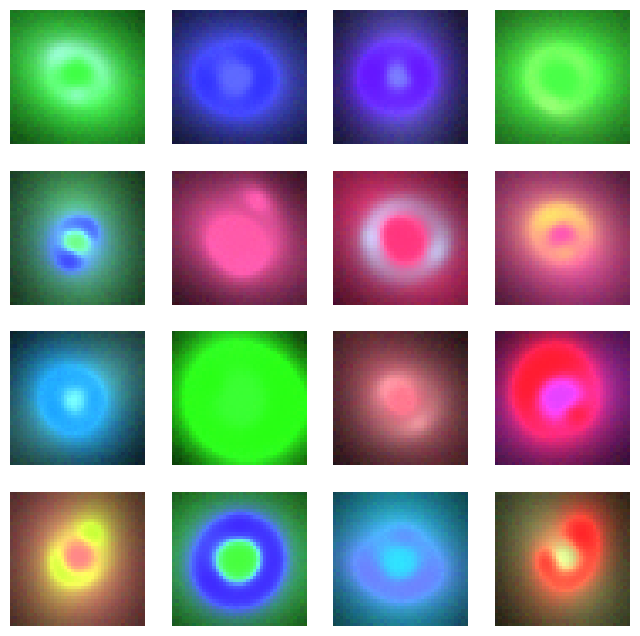

In [4]:
# Visualize source data
visualize_data(source_data)

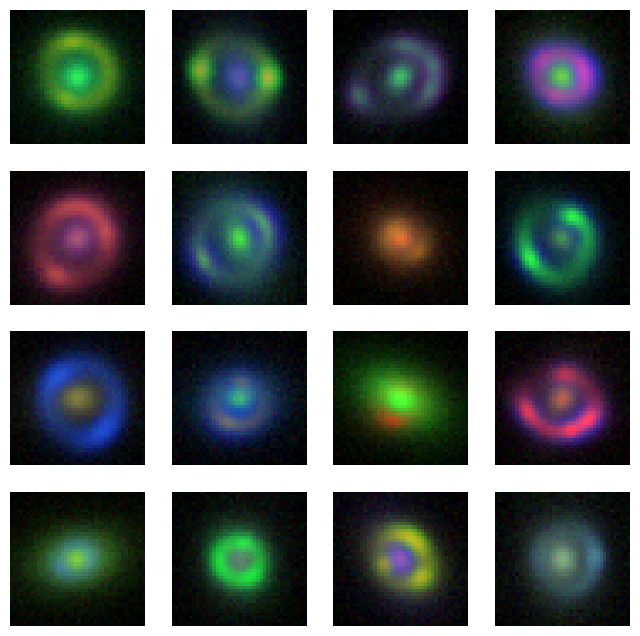

In [5]:
# Visualize target data
visualize_data(target_data)

In [6]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self, npix):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [7]:
def loss_bnll(mean, variance, truth, beta, epsilon = 1e-7):  # beta=0.5):
    """Compute beta-NLL loss

    :param mean: Predicted mean of shape B x D
    :param variance: Predicted variance of shape B x D
    :param truth: truth of shape B x D
    :param beta: Parameter from range [0, 1] controlling relative
        weighting between data points, where `0` corresponds to
        high weight on low error points and `1` to an equal weighting.
    :returns: Loss per batch element of shape B
    """
    variance = variance + epsilon
    loss = 0.5 * ((truth - mean) ** 2 / variance + variance.log())
    if beta > 0:
        loss = loss * (variance.detach() ** beta)
    return loss.sum(axis=-1) / len(mean)

In [8]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch,
               init_wt_da,
               final_wt_da,
               beta_init,
               beta_final):
               # init_wt_mve,
               # final_wt_mve):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    mve_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)
        mean = estimate_output[:, 0]
        variance = estimate_output[:, 1]

        # print(y.shape)
        # print(mean.shape)
        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(mean, y)

        
        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)
        beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)

        if ((epoch / n_epoch) > 0.5):
            beta_val = beta_final

        
        mve_loss = loss_bnll(mean.flatten(), variance.flatten(), y, beta = beta_val)
        
        # Hyperparameter of da_weight set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
        # mve_weight_power = (init_wt_mve - ((init_wt_mve - final_wt_mve) * (epoch / n_epoch)))
        # mve_weight = 10 ** (-mve_weight_power)

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), mean.cpu().detach().numpy())

        loss = mve_loss + domain_loss * da_weight 

        
        
        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        mve_error += mve_loss.item()

        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader
    mve_error /= len_dataloader

    return [domain_error, estimator_error, mve_error, score]

In [9]:
def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch,
              beta_init,
              beta_final):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        mve_error = 0
        mve_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)
            source_mean = estimate_output[:, 0]
            source_variance = estimate_output[:, 1]
            beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)

            if ((epoch / n_epoch) > 0.5):
                beta_val = beta_final
            
            estimate_loss = regressor_loss_fn(source_mean, y)
            mve_loss = loss_bnll(source_mean.flatten(), source_variance.flatten(), y, beta = beta_val)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)
            target_mean = estimate_output_target[:, 0]
            target_variance = estimate_output_target[:, 1]
            
            estimate_loss_target = regressor_loss_fn(target_mean, y_target)
            mve_loss_target = loss_bnll(target_mean.flatten(), target_variance.flatten(), y_target, beta = beta_val)
            
            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # MVE loss on validation testing
            mve_error += mve_loss.item()
            mve_error_target += mve_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), source_mean.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), target_mean.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        mve_error /= len_dataloader
        mve_error_target /= len_dataloader
        
    classifier_error = 1 # UNUSED, legacy
    return [classifier_error, estimator_error, estimator_error_target, score, score_target, mve_error, mve_error_target]

In [10]:
model = NeuralNetwork(npix=40).cuda()
learning_rate = 2e-5
epochs = 75
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [11]:
mod_name = None#"models/mb_lenscolor_jul25_1700" #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_mve_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
             'val_source_mve_loss': [],
             'val_target_mve_loss': [],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


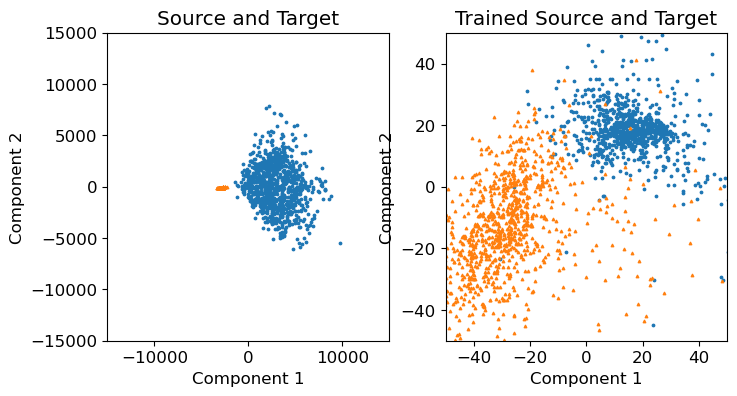

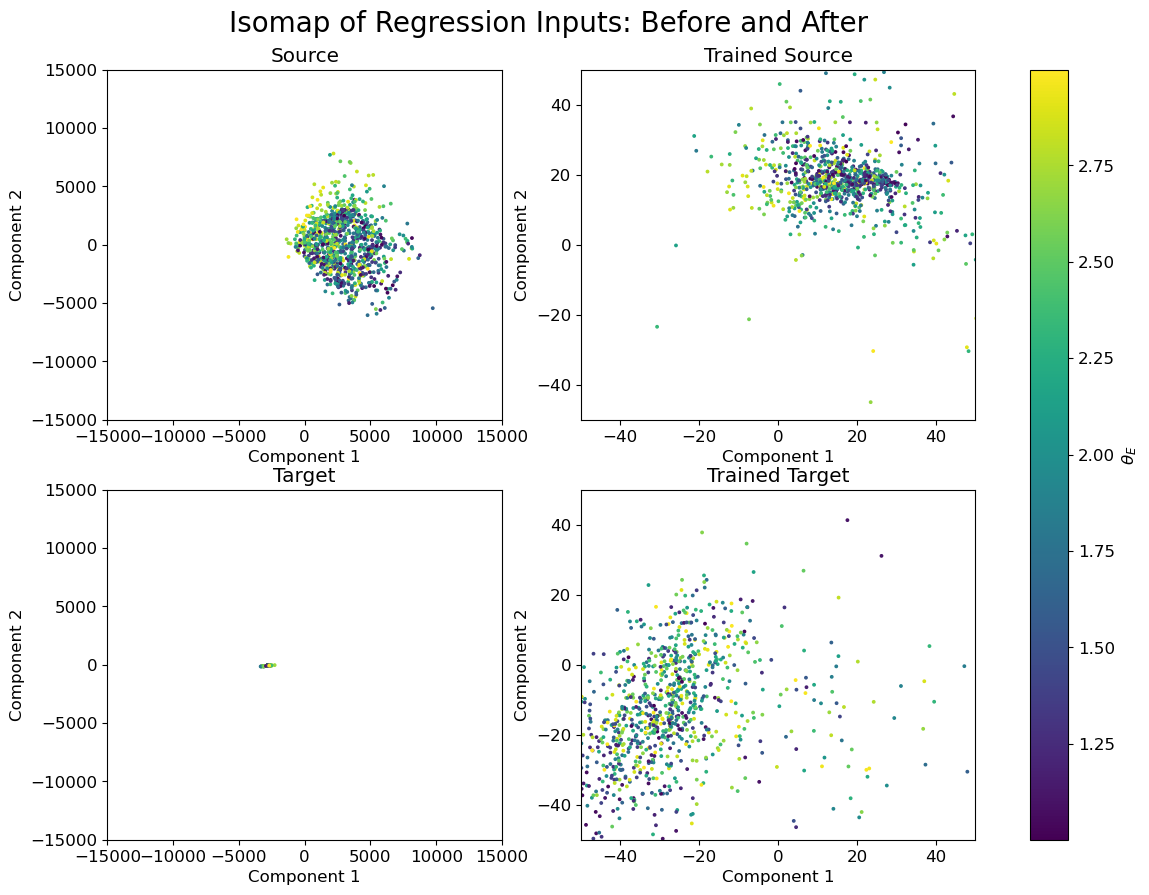


Epoch 0: 16.62s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3768
	Train Regression Loss: : 0.9860
	Train Mve Loss: : 0.4409
	Train R2 Score: : -2.1077
 Validation Statistics:
	Val Source Regression Loss: : 0.1723
	Val Target Regression Loss: : 0.2009
	Val Source R2 Score: : 0.4604
	Val Target R2 Score: : 0.3622
	Val Source Mve Loss: : -0.0662
	Val Target Mve Loss: : -0.0478
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 14.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2209
	Train Regression Loss: : 0.1065
	Train Mve Loss: : -0.0813
	Train R2 Score: : 0.6651
 Validation Statistics:
	Val Source Regression Loss: : 0.0763
	Val Target Regression Loss: : 0.1001
	Val Source R2 Score: : 0.7568
	Val Target R2 Score: : 0.6838
	Val Source Mve Loss: : -0.0874
	Val Target Mve Loss: : -0.0702
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 15.96s
-------------------------------
 Training Statistics:
	Train Da Loss: :

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


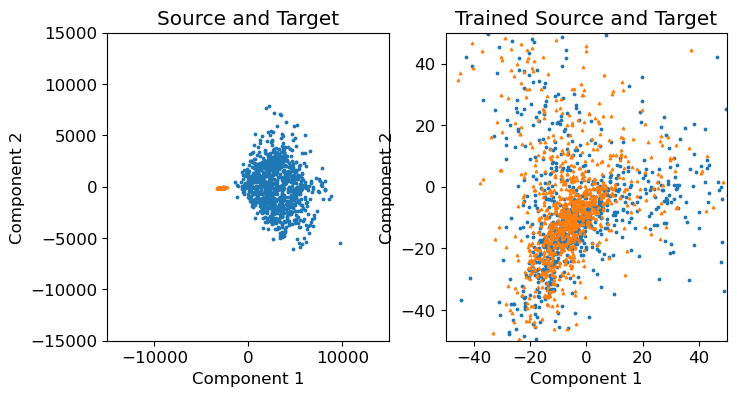

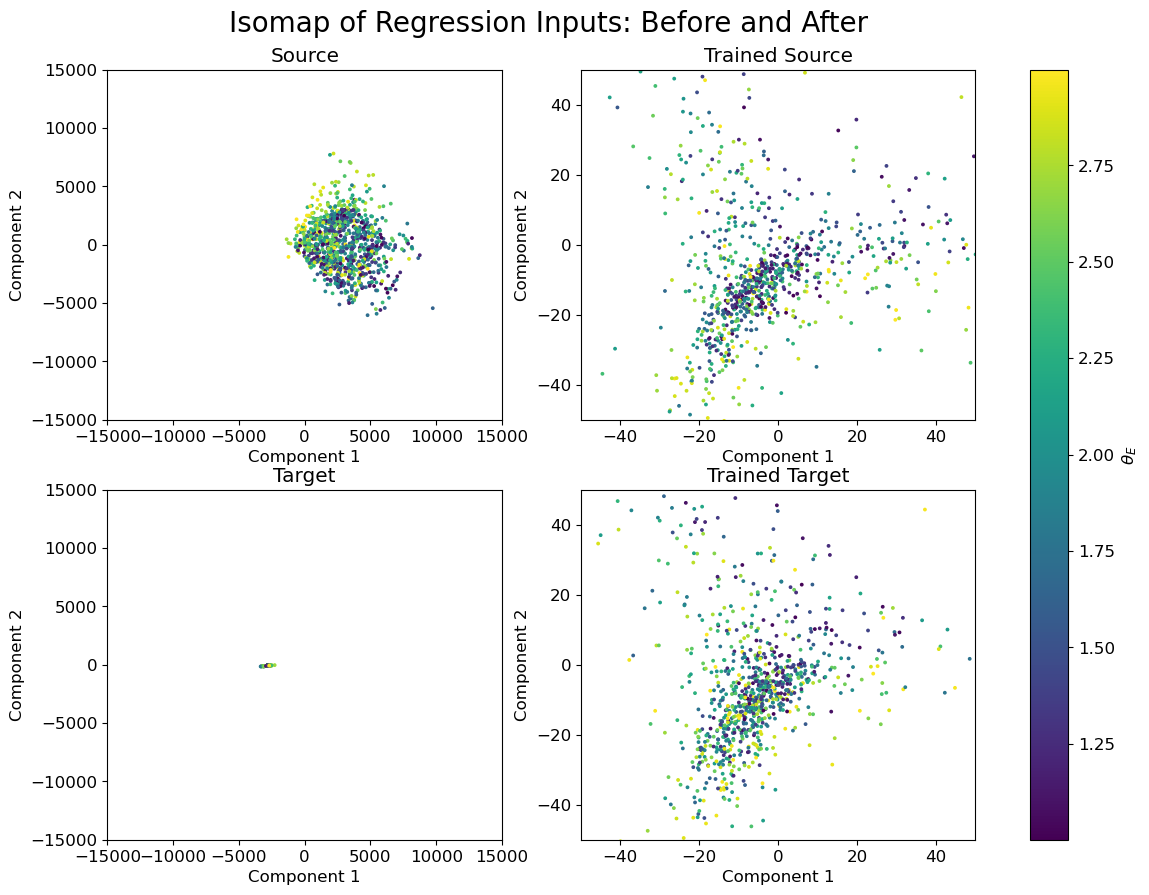

Saving Model... Done.
Saving Model MVE... Done.

Epoch 5: 16.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1527
	Train Regression Loss: : 0.0481
	Train Mve Loss: : -0.1080
	Train R2 Score: : 0.8489
 Validation Statistics:
	Val Source Regression Loss: : 0.0512
	Val Target Regression Loss: : 0.0600
	Val Source R2 Score: : 0.8409
	Val Target R2 Score: : 0.8104
	Val Source Mve Loss: : -0.0766
	Val Target Mve Loss: : -0.0720
Saving Model... Done.
Saving Model MVE... Done.

Epoch 6: 14.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1488
	Train Regression Loss: : 0.0454
	Train Mve Loss: : -0.0985
	Train R2 Score: : 0.8576
 Validation Statistics:
	Val Source Regression Loss: : 0.0474
	Val Target Regression Loss: : 0.0554
	Val Source R2 Score: : 0.8495
	Val Target R2 Score: : 0.8246
	Val Source Mve Loss: : -0.1278
	Val Target Mve Loss: : -0.1243
Saving Model... Done.
Saving Model MVE... Done.

Epoch 7: 14.83s
-----------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


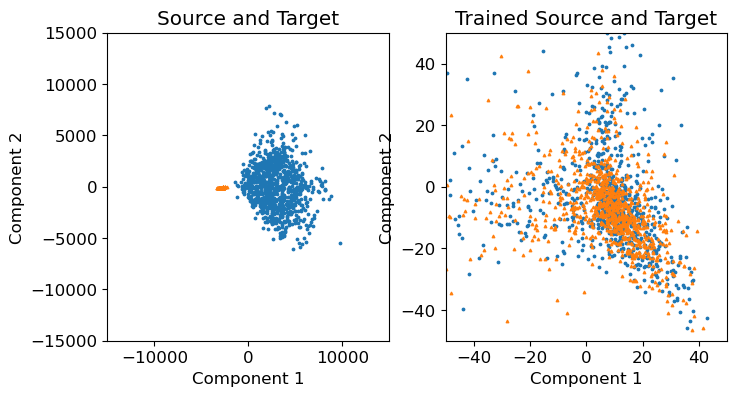

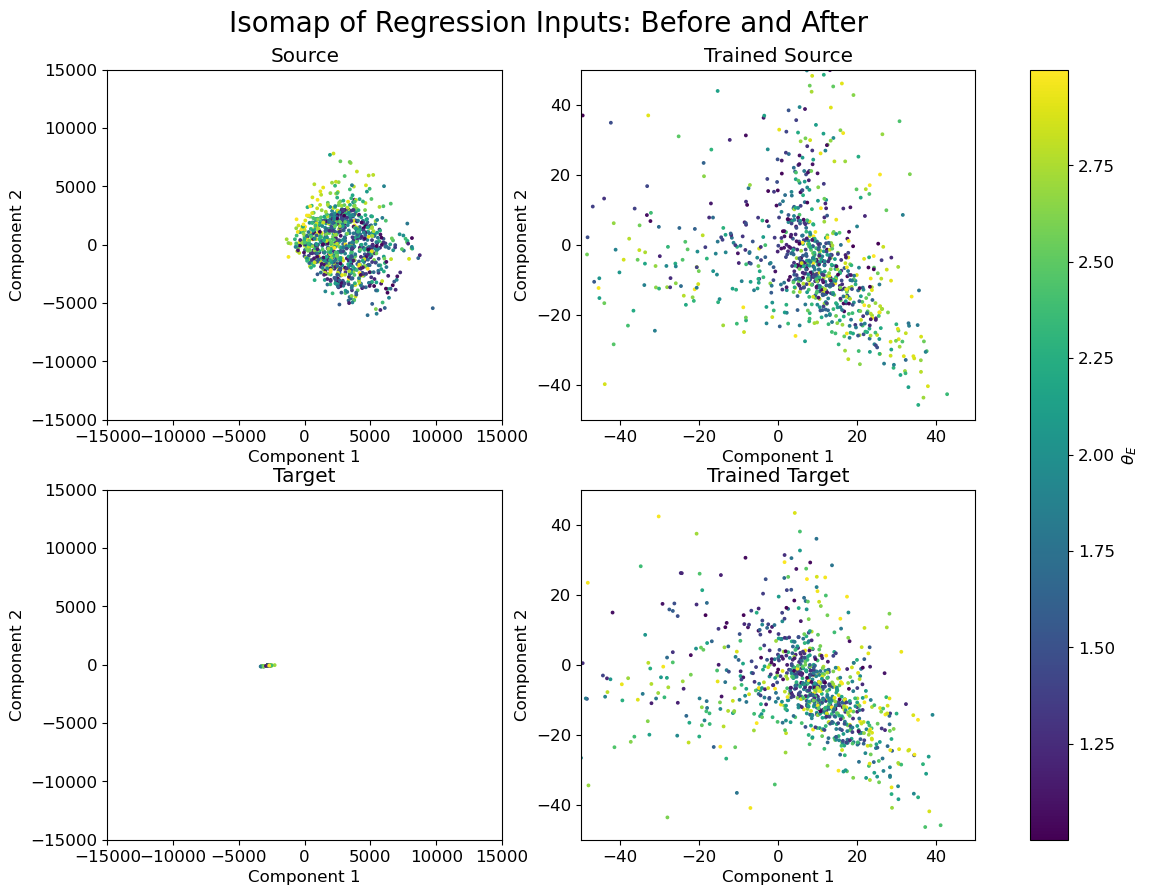

Saving Model MVE... Done.

Epoch 10: 13.55s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1397
	Train Regression Loss: : 0.0385
	Train Mve Loss: : -0.1228
	Train R2 Score: : 0.8784
 Validation Statistics:
	Val Source Regression Loss: : 0.0413
	Val Target Regression Loss: : 0.0449
	Val Source R2 Score: : 0.8721
	Val Target R2 Score: : 0.8575
	Val Source Mve Loss: : -0.0864
	Val Target Mve Loss: : -0.0819
Saving Model... Done.
Saving Model MVE... Done.

Epoch 11: 13.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1371
	Train Regression Loss: : 0.0359
	Train Mve Loss: : -0.0896
	Train R2 Score: : 0.8869
 Validation Statistics:
	Val Source Regression Loss: : 0.0396
	Val Target Regression Loss: : 0.0440
	Val Source R2 Score: : 0.8751
	Val Target R2 Score: : 0.8617
	Val Source Mve Loss: : -0.0631
	Val Target Mve Loss: : -0.0597
Saving Model... Done.
Saving Model MVE... Done.

Epoch 12: 15.53s
-------------------------------
 Training 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


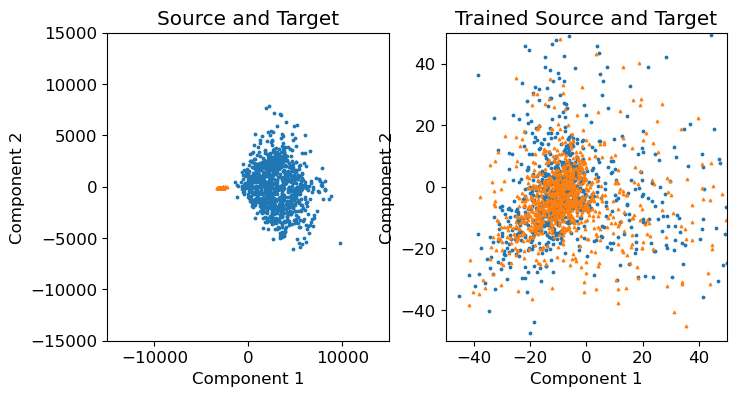

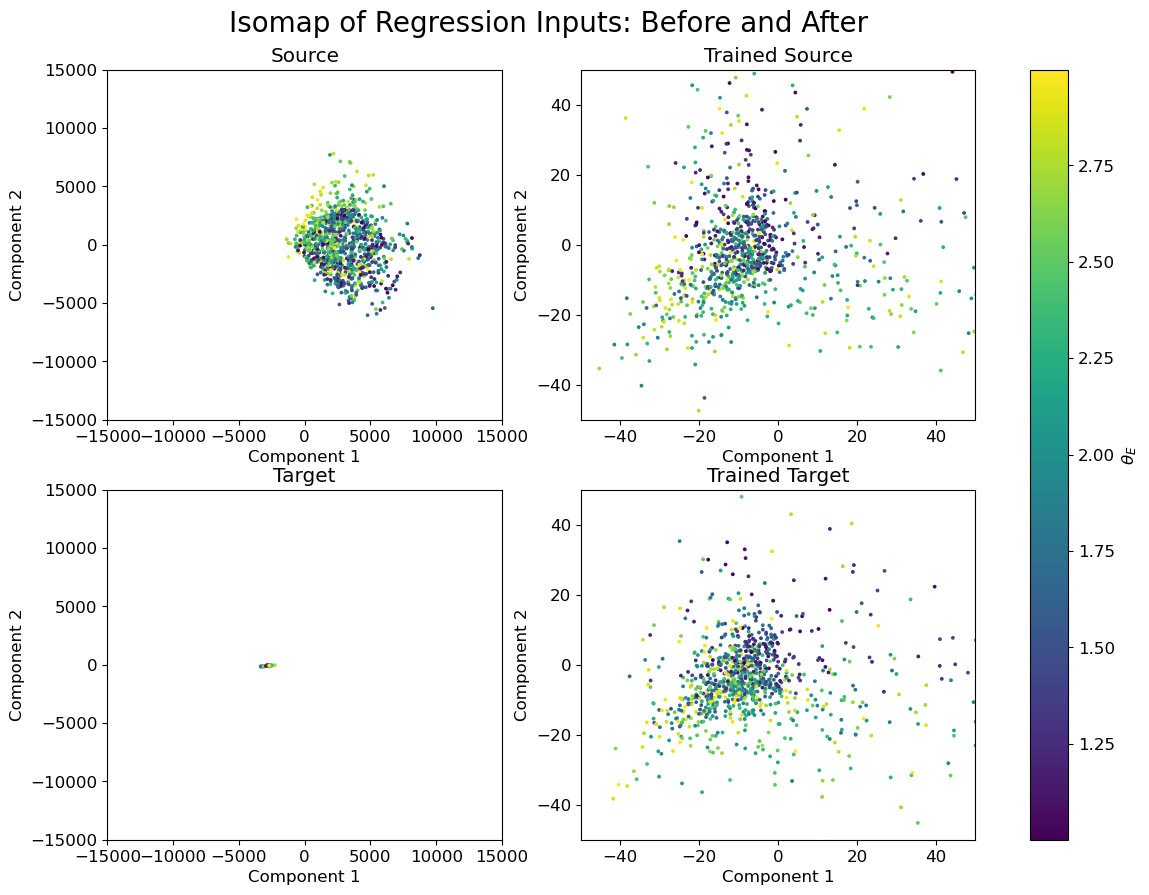

Saving Model... Done.
Saving Model MVE... Done.

Epoch 15: 15.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1289
	Train Regression Loss: : 0.0305
	Train Mve Loss: : -0.1052
	Train R2 Score: : 0.9043
 Validation Statistics:
	Val Source Regression Loss: : 0.0343
	Val Target Regression Loss: : 0.0409
	Val Source R2 Score: : 0.8909
	Val Target R2 Score: : 0.8639
	Val Source Mve Loss: : -0.0829
	Val Target Mve Loss: : -0.0821
Saving Model MVE... Done.

Epoch 16: 15.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1257
	Train Regression Loss: : 0.0304
	Train Mve Loss: : -0.1121
	Train R2 Score: : 0.9047
 Validation Statistics:
	Val Source Regression Loss: : 0.0323
	Val Target Regression Loss: : 0.0378
	Val Source R2 Score: : 0.8993
	Val Target R2 Score: : 0.8802
	Val Source Mve Loss: : -0.0726
	Val Target Mve Loss: : -0.0663
Saving Model... Done.
Saving Model MVE... Done.

Epoch 17: 13.93s
-------------------------------
 Training 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


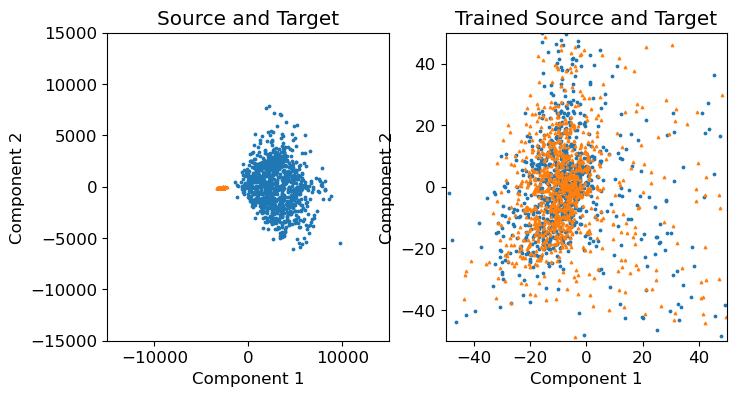

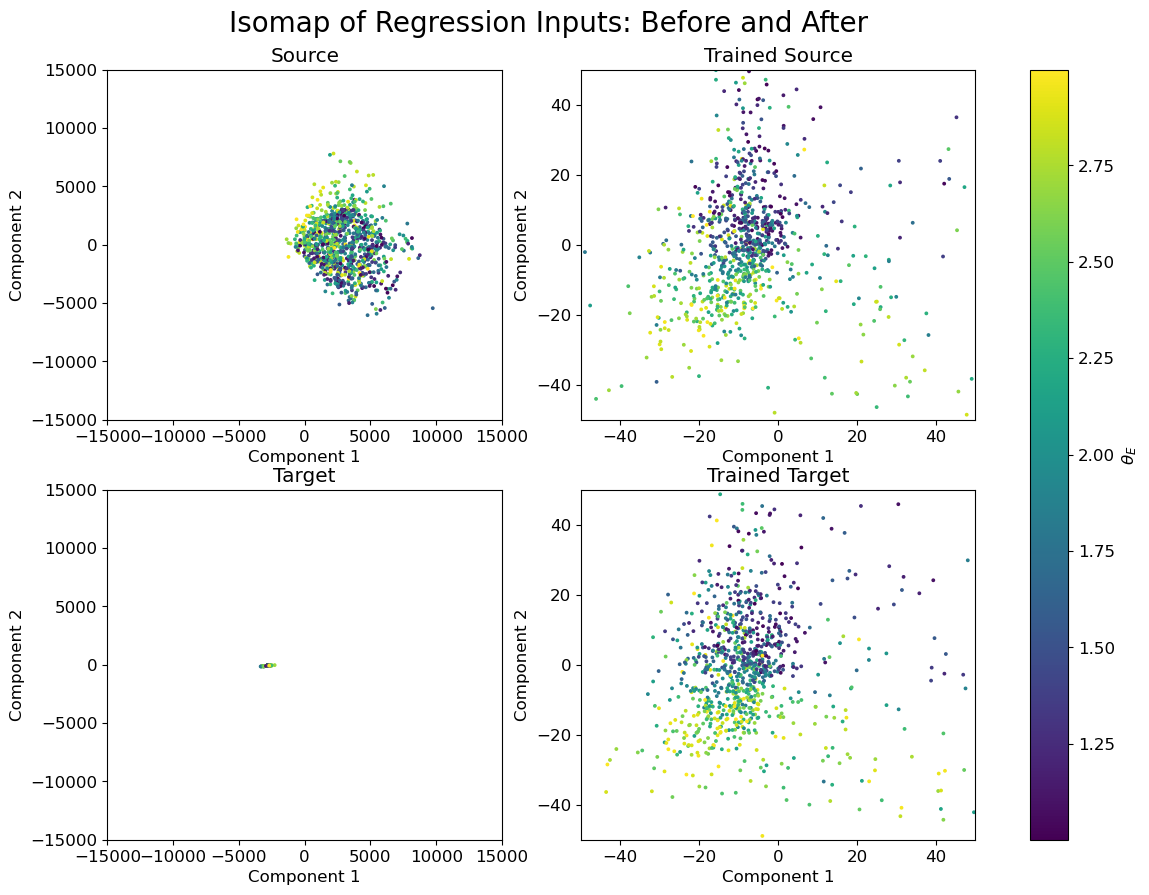

Saving Model... Done.
Saving Model MVE... Done.

Epoch 20: 14.57s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1208
	Train Regression Loss: : 0.0272
	Train Mve Loss: : -0.0864
	Train R2 Score: : 0.9147
 Validation Statistics:
	Val Source Regression Loss: : 0.0280
	Val Target Regression Loss: : 0.0340
	Val Source R2 Score: : 0.9123
	Val Target R2 Score: : 0.8924
	Val Source Mve Loss: : -0.1412
	Val Target Mve Loss: : -0.1348
Saving Model... Done.
Saving Model MVE... Done.

Epoch 21: 12.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1188
	Train Regression Loss: : 0.0256
	Train Mve Loss: : -0.0964
	Train R2 Score: : 0.9195
 Validation Statistics:
	Val Source Regression Loss: : 0.0277
	Val Target Regression Loss: : 0.0316
	Val Source R2 Score: : 0.9131
	Val Target R2 Score: : 0.9006
	Val Source Mve Loss: : -0.0595
	Val Target Mve Loss: : -0.0538
Saving Model... Done.
Saving Model MVE... Done.

Epoch 22: 13.97s
--------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


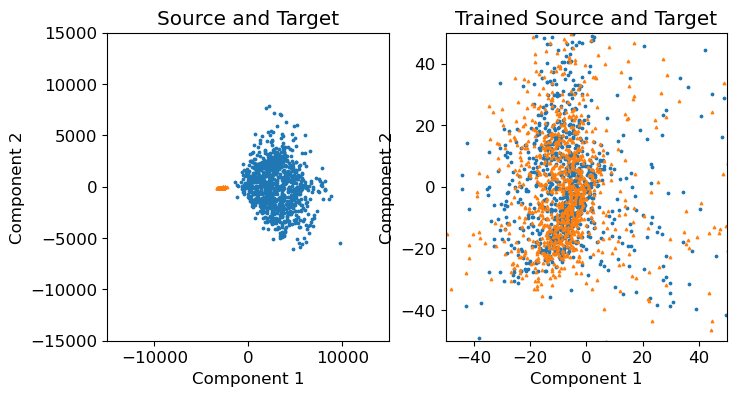

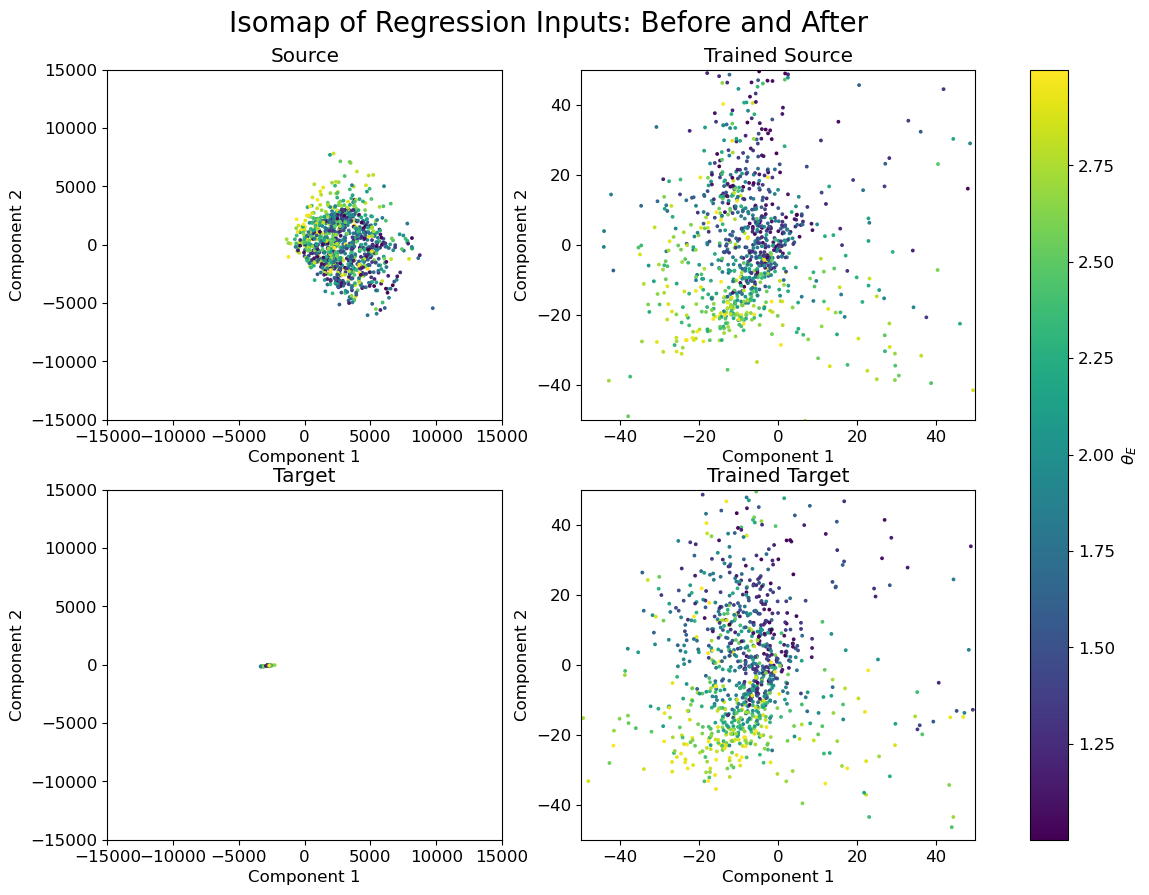

Saving Model MVE... Done.

Epoch 25: 14.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1176
	Train Regression Loss: : 0.0235
	Train Mve Loss: : -0.1234
	Train R2 Score: : 0.9261
 Validation Statistics:
	Val Source Regression Loss: : 0.0268
	Val Target Regression Loss: : 0.0304
	Val Source R2 Score: : 0.9164
	Val Target R2 Score: : 0.9034
	Val Source Mve Loss: : -0.1149
	Val Target Mve Loss: : -0.1056
Saving Model... Done.
Saving Model MVE... Done.

Epoch 26: 15.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1170
	Train Regression Loss: : 0.0231
	Train Mve Loss: : -0.0805
	Train R2 Score: : 0.9276
 Validation Statistics:
	Val Source Regression Loss: : 0.0259
	Val Target Regression Loss: : 0.0297
	Val Source R2 Score: : 0.9165
	Val Target R2 Score: : 0.9053
	Val Source Mve Loss: : -0.1257
	Val Target Mve Loss: : -0.1160
Saving Model... Done.
Saving Model MVE... Done.

Epoch 27: 15.22s
-------------------------------
 Training 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


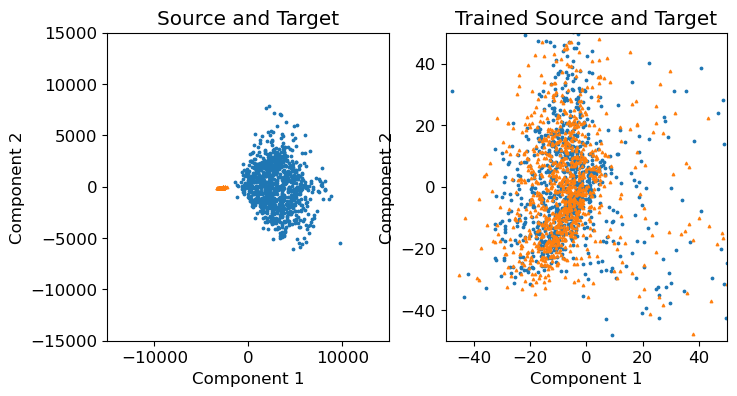

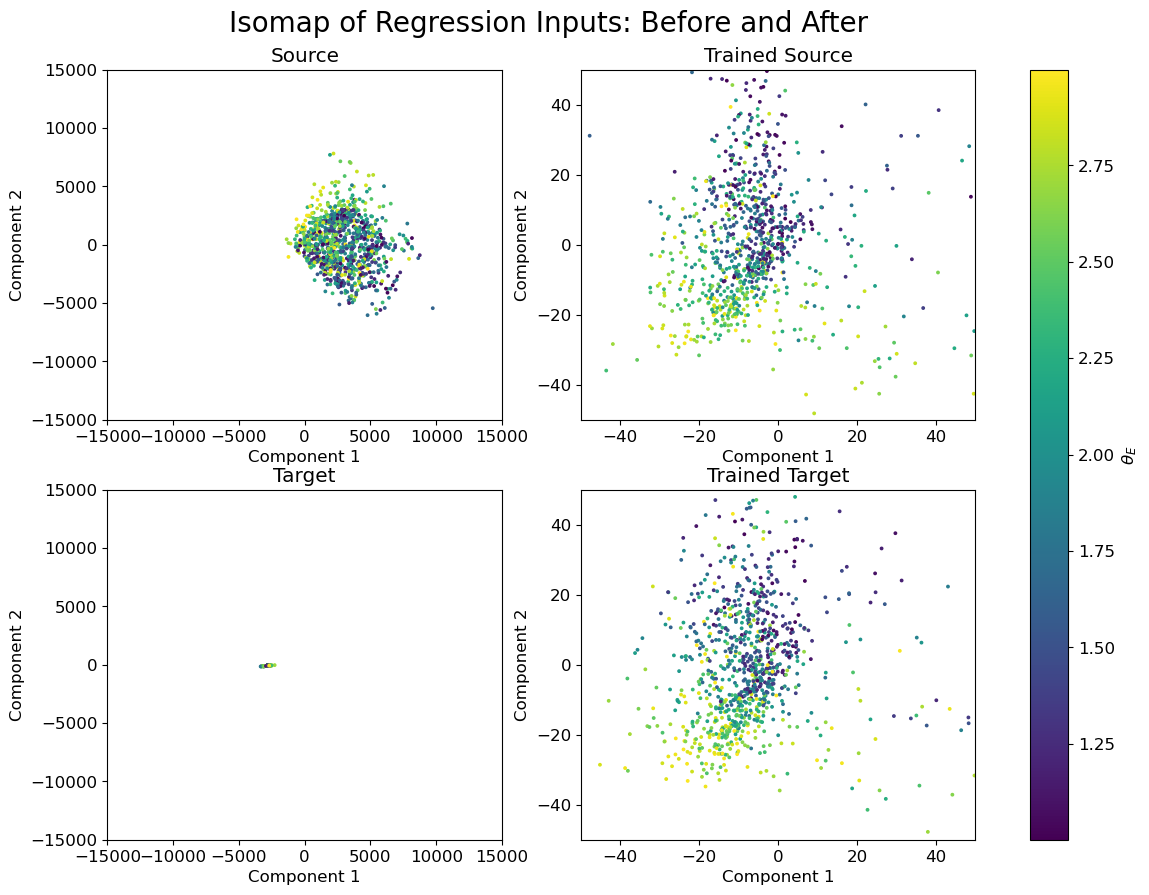

Saving Model... Done.
Saving Model MVE... Done.

Epoch 30: 17.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1135
	Train Regression Loss: : 0.0221
	Train Mve Loss: : 0.0082
	Train R2 Score: : 0.9307
 Validation Statistics:
	Val Source Regression Loss: : 0.0243
	Val Target Regression Loss: : 0.0283
	Val Source R2 Score: : 0.9248
	Val Target R2 Score: : 0.9099
	Val Source Mve Loss: : 0.0766
	Val Target Mve Loss: : 0.1224
Saving Model... Done.
Saving Model MVE... Done.

Epoch 31: 14.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1146
	Train Regression Loss: : 0.0222
	Train Mve Loss: : -0.0614
	Train R2 Score: : 0.9304
 Validation Statistics:
	Val Source Regression Loss: : 0.0237
	Val Target Regression Loss: : 0.0265
	Val Source R2 Score: : 0.9255
	Val Target R2 Score: : 0.9158
	Val Source Mve Loss: : -0.0816
	Val Target Mve Loss: : -0.0684
Saving Model... Done.
Saving Model MVE... Done.

Epoch 32: 15.17s
-----------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


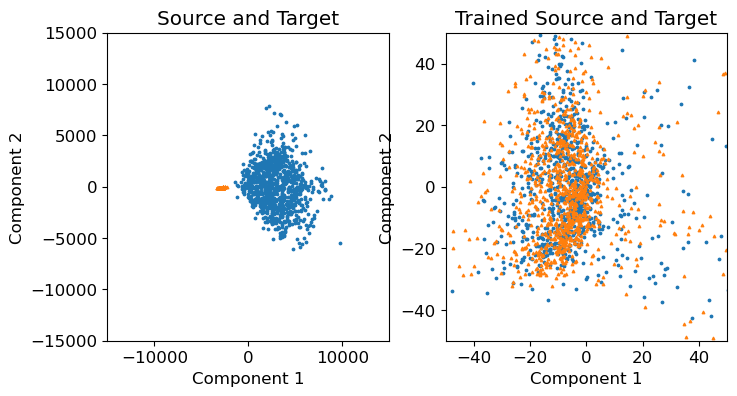

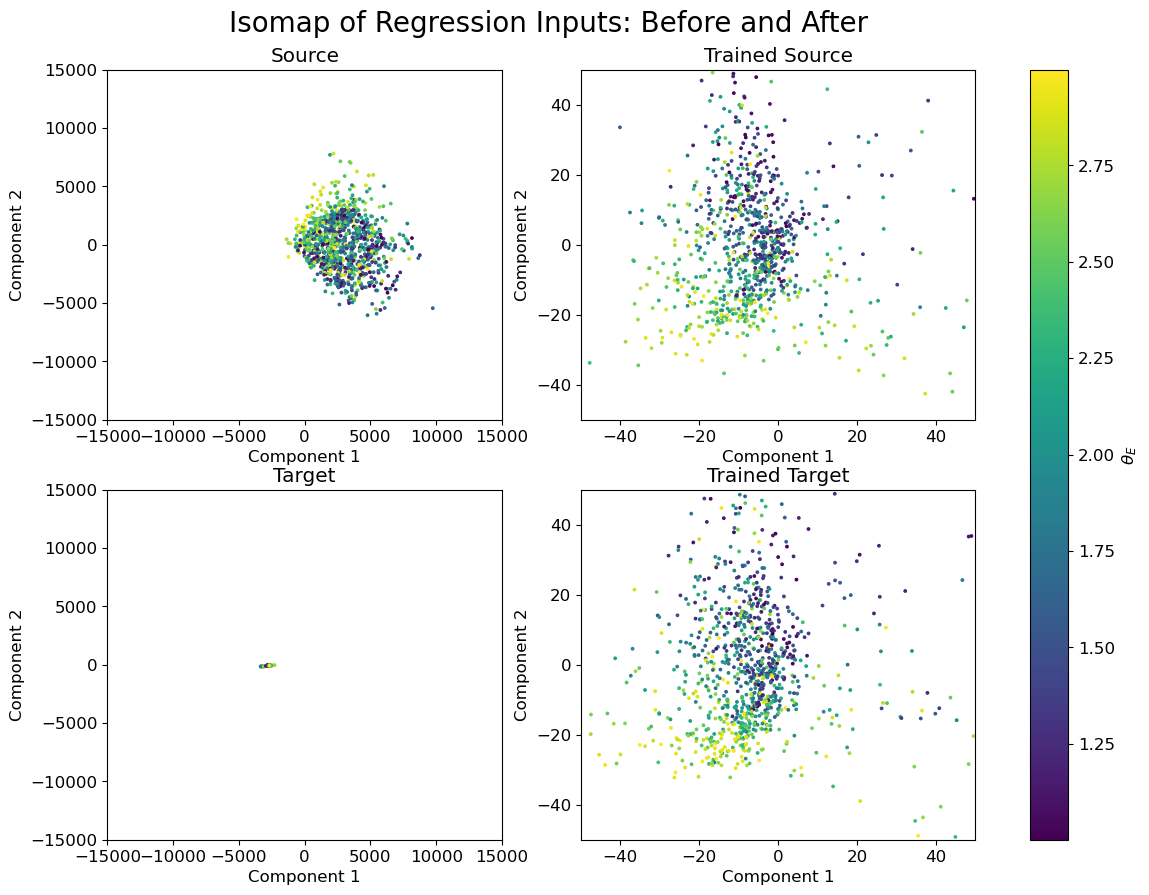

Saving Model MVE... Done.

Epoch 35: 12.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1136
	Train Regression Loss: : 0.0229
	Train Mve Loss: : -0.1110
	Train R2 Score: : 0.9280
 Validation Statistics:
	Val Source Regression Loss: : 0.0253
	Val Target Regression Loss: : 0.0293
	Val Source R2 Score: : 0.9203
	Val Target R2 Score: : 0.9063
	Val Source Mve Loss: : -0.0334
	Val Target Mve Loss: : -0.0045
Saving Model MVE... Done.

Epoch 36: 13.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1143
	Train Regression Loss: : 0.0232
	Train Mve Loss: : -0.0977
	Train R2 Score: : 0.9271
 Validation Statistics:
	Val Source Regression Loss: : 0.0260
	Val Target Regression Loss: : 0.0288
	Val Source R2 Score: : 0.9181
	Val Target R2 Score: : 0.9087
	Val Source Mve Loss: : -0.0997
	Val Target Mve Loss: : -0.1132
Saving Model MVE... Done.

Epoch 37: 13.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1143
	Train 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


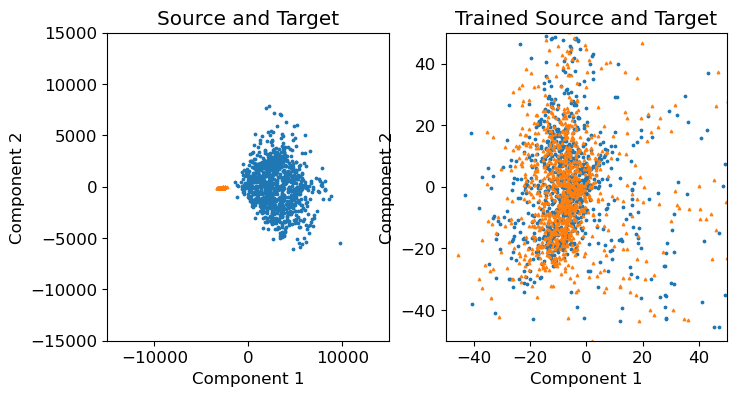

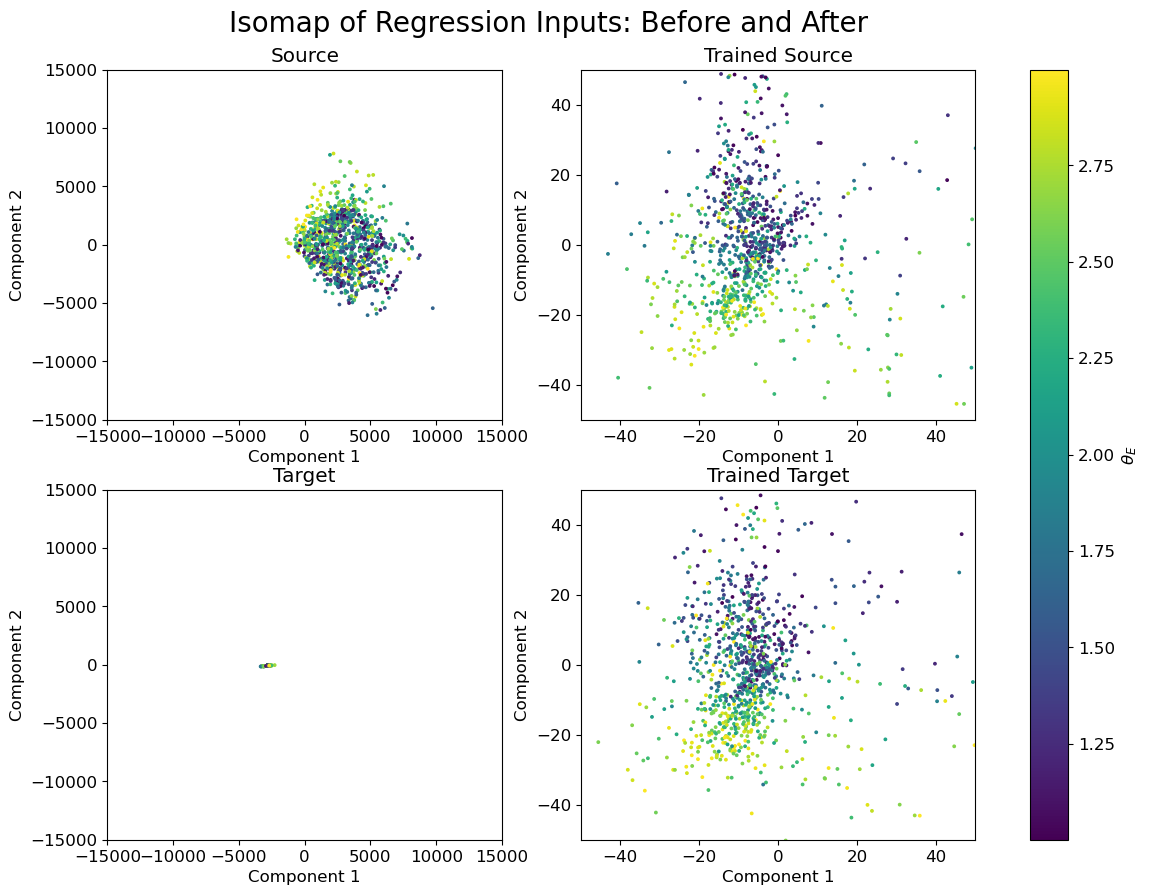


Epoch 40: 14.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1170
	Train Regression Loss: : 0.0266
	Train Mve Loss: : 3.8618
	Train R2 Score: : 0.9158
 Validation Statistics:
	Val Source Regression Loss: : 0.0277
	Val Target Regression Loss: : 0.0326
	Val Source R2 Score: : 0.9128
	Val Target R2 Score: : 0.8958
	Val Source Mve Loss: : 3.2932
	Val Target Mve Loss: : 1.7373

Epoch 41: 15.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1174
	Train Regression Loss: : 0.0279
	Train Mve Loss: : 3.1228
	Train R2 Score: : 0.9120
 Validation Statistics:
	Val Source Regression Loss: : 0.0324
	Val Target Regression Loss: : 0.0374
	Val Source R2 Score: : 0.8990
	Val Target R2 Score: : 0.8790
	Val Source Mve Loss: : 7.6183
	Val Target Mve Loss: : 7.2791

Epoch 42: 13.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1185
	Train Regression Loss: : 0.0291
	Train Mve Loss: : 2.8475
	Train R2 Score: : 0.9080
 Valid

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


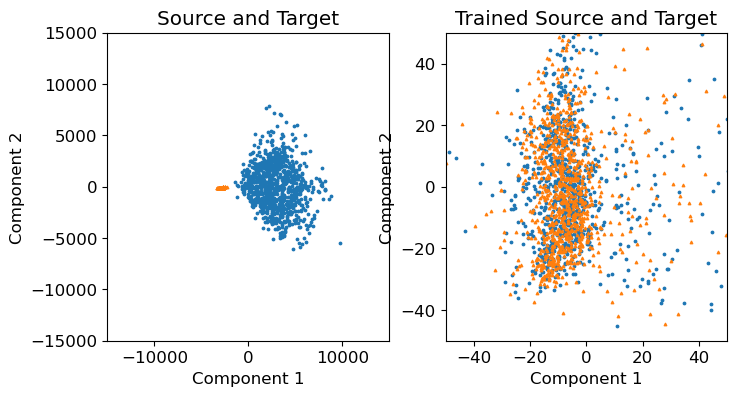

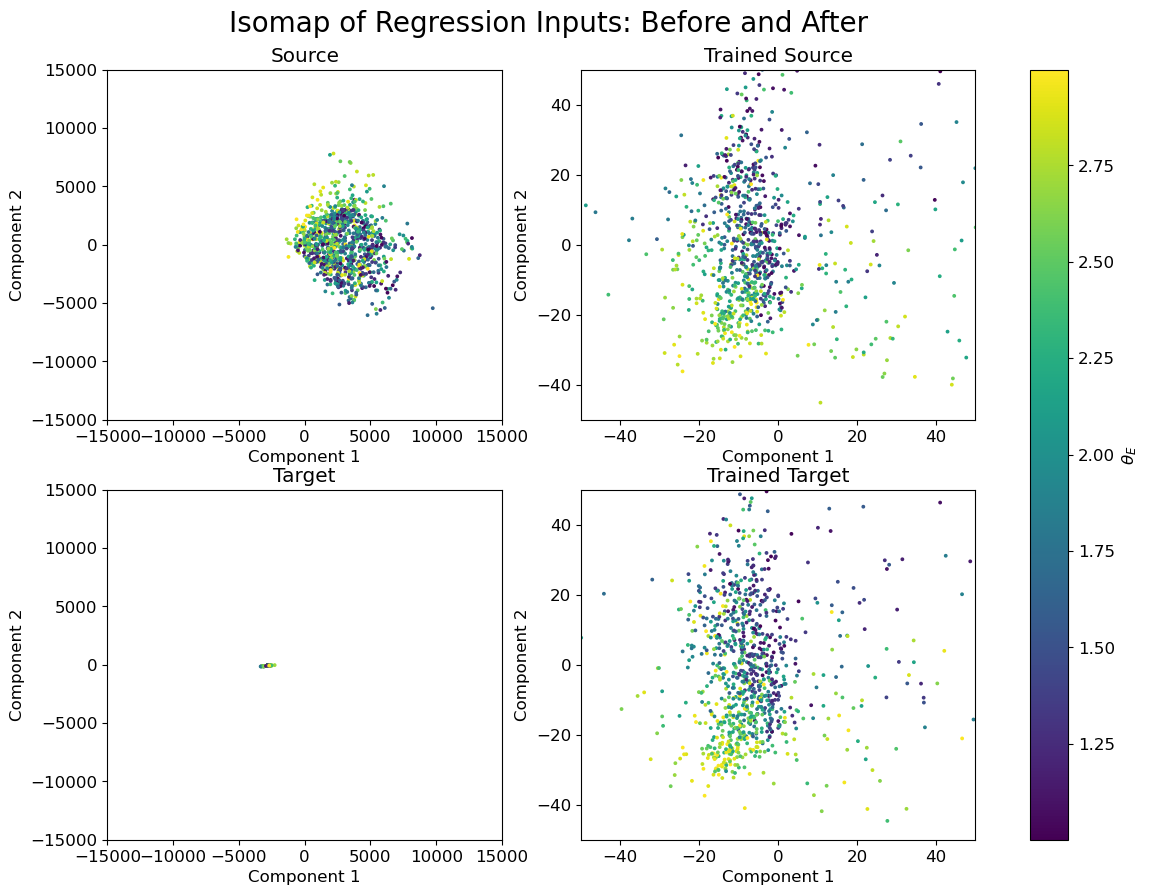

Saving Model MVE... Done.

Epoch 45: 12.84s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1216
	Train Regression Loss: : 0.0335
	Train Mve Loss: : 1.5504
	Train R2 Score: : 0.8936
 Validation Statistics:
	Val Source Regression Loss: : 0.0615
	Val Target Regression Loss: : 0.0649
	Val Source R2 Score: : 0.8076
	Val Target R2 Score: : 0.7933
	Val Source Mve Loss: : 23.9389
	Val Target Mve Loss: : 13.2928

Epoch 46: 14.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1246
	Train Regression Loss: : 0.0327
	Train Mve Loss: : 4.8099
	Train R2 Score: : 0.8965
 Validation Statistics:
	Val Source Regression Loss: : 0.0334
	Val Target Regression Loss: : 0.0386
	Val Source R2 Score: : 0.8960
	Val Target R2 Score: : 0.8754
	Val Source Mve Loss: : 13.1259
	Val Target Mve Loss: : 11.6972

Epoch 47: 14.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1266
	Train Regression Loss: : 0.0269
	Train Mve Loss: : 4.0139
	T

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


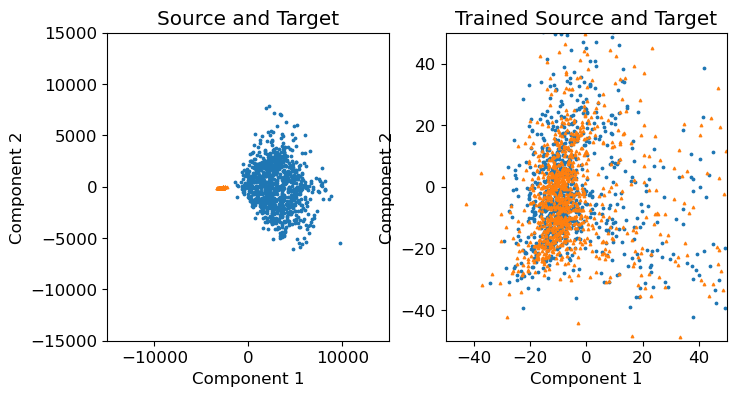

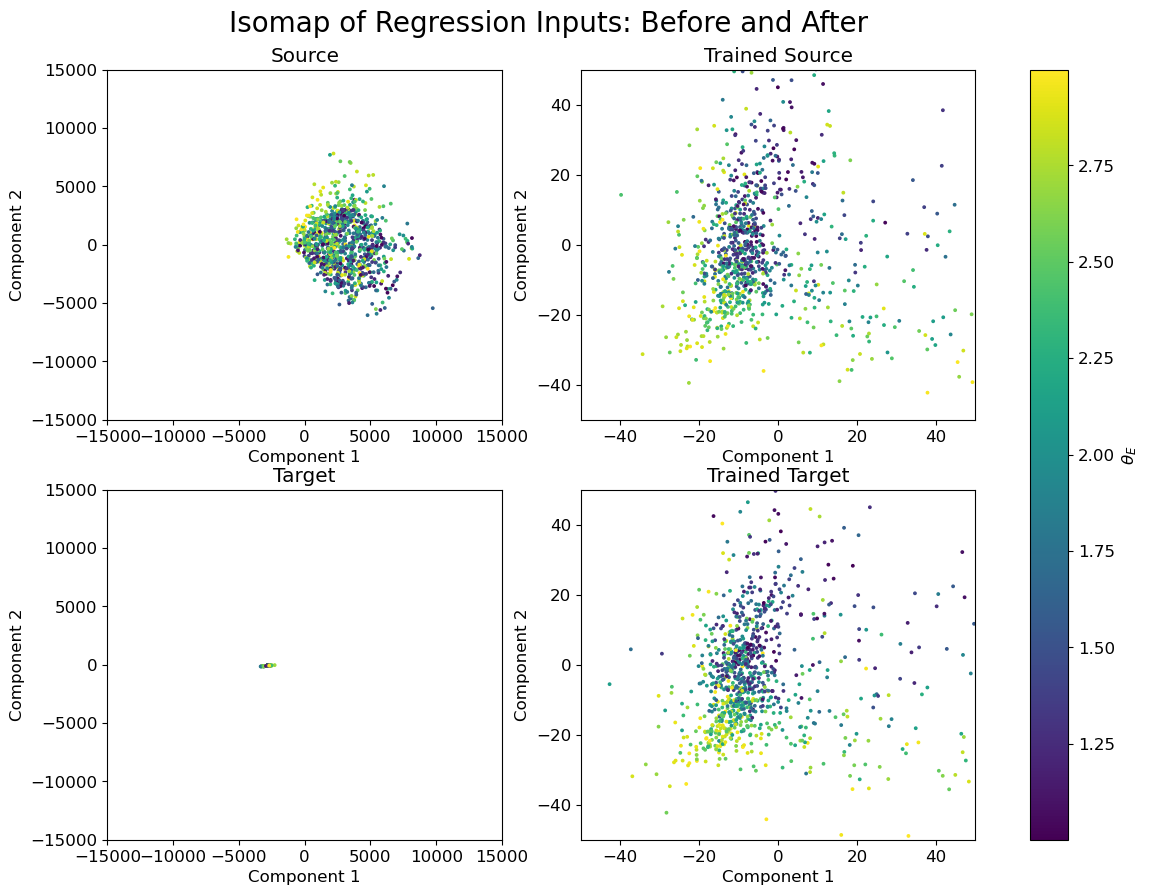

Saving Model MVE... Done.

Epoch 50: 14.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1290
	Train Regression Loss: : 0.0334
	Train Mve Loss: : 0.2036
	Train R2 Score: : 0.8948
 Validation Statistics:
	Val Source Regression Loss: : 0.0707
	Val Target Regression Loss: : 0.0677
	Val Source R2 Score: : 0.7782
	Val Target R2 Score: : 0.7844
	Val Source Mve Loss: : 2.6492
	Val Target Mve Loss: : 0.8888
Saving Model MVE... Done.

Epoch 51: 14.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1329
	Train Regression Loss: : 0.0415
	Train Mve Loss: : 2.0154
	Train R2 Score: : 0.8685
 Validation Statistics:
	Val Source Regression Loss: : 0.0273
	Val Target Regression Loss: : 0.0293
	Val Source R2 Score: : 0.9145
	Val Target R2 Score: : 0.9066
	Val Source Mve Loss: : 3.9667
	Val Target Mve Loss: : 3.3236

Epoch 52: 14.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1370
	Train Regression Loss: : 0.0260
	Train

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


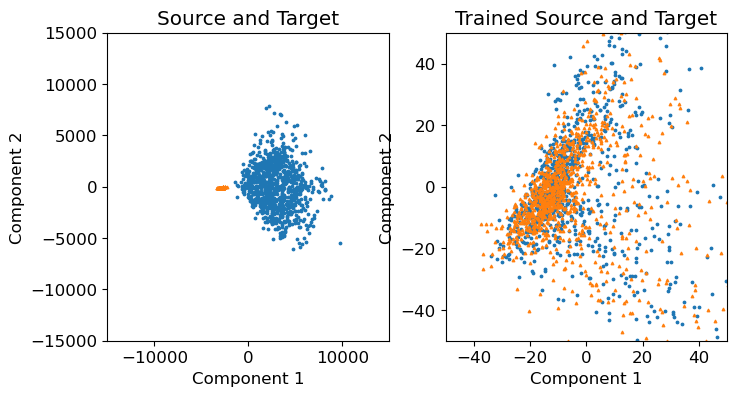

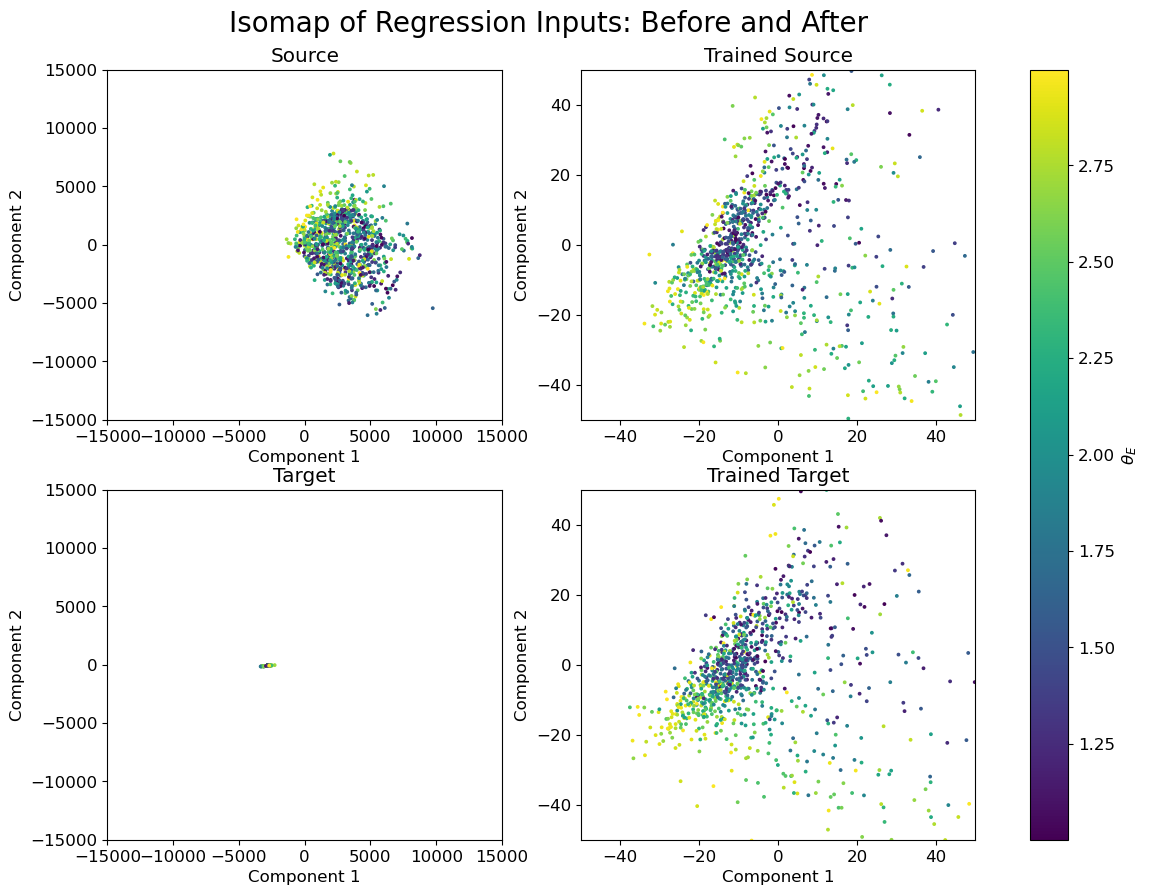

Saving Model... Done.

Epoch 55: 14.49s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1356
	Train Regression Loss: : 0.0352
	Train Mve Loss: : 0.3103
	Train R2 Score: : 0.8889
 Validation Statistics:
	Val Source Regression Loss: : 0.0333
	Val Target Regression Loss: : 0.0383
	Val Source R2 Score: : 0.8947
	Val Target R2 Score: : 0.8783
	Val Source Mve Loss: : -0.1635
	Val Target Mve Loss: : -0.1636
Saving Model MVE... Done.

Epoch 56: 13.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1363
	Train Regression Loss: : 0.0295
	Train Mve Loss: : -0.1498
	Train R2 Score: : 0.9064
 Validation Statistics:
	Val Source Regression Loss: : 0.0277
	Val Target Regression Loss: : 0.0328
	Val Source R2 Score: : 0.9139
	Val Target R2 Score: : 0.8941
	Val Source Mve Loss: : 0.2171
	Val Target Mve Loss: : -0.1837
Saving Model MVE... Done.

Epoch 57: 13.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1378
	Train Regres

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


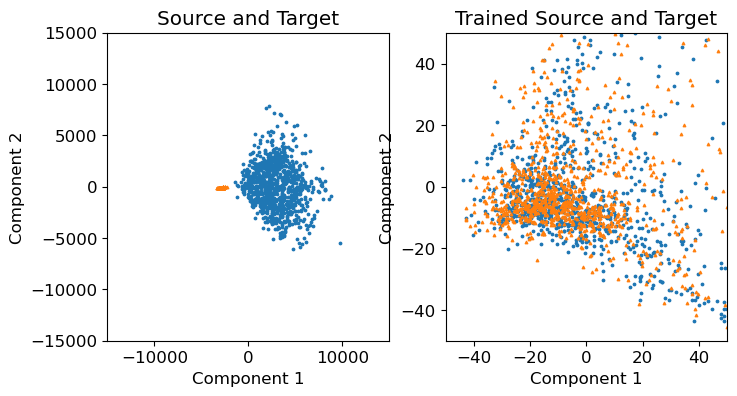

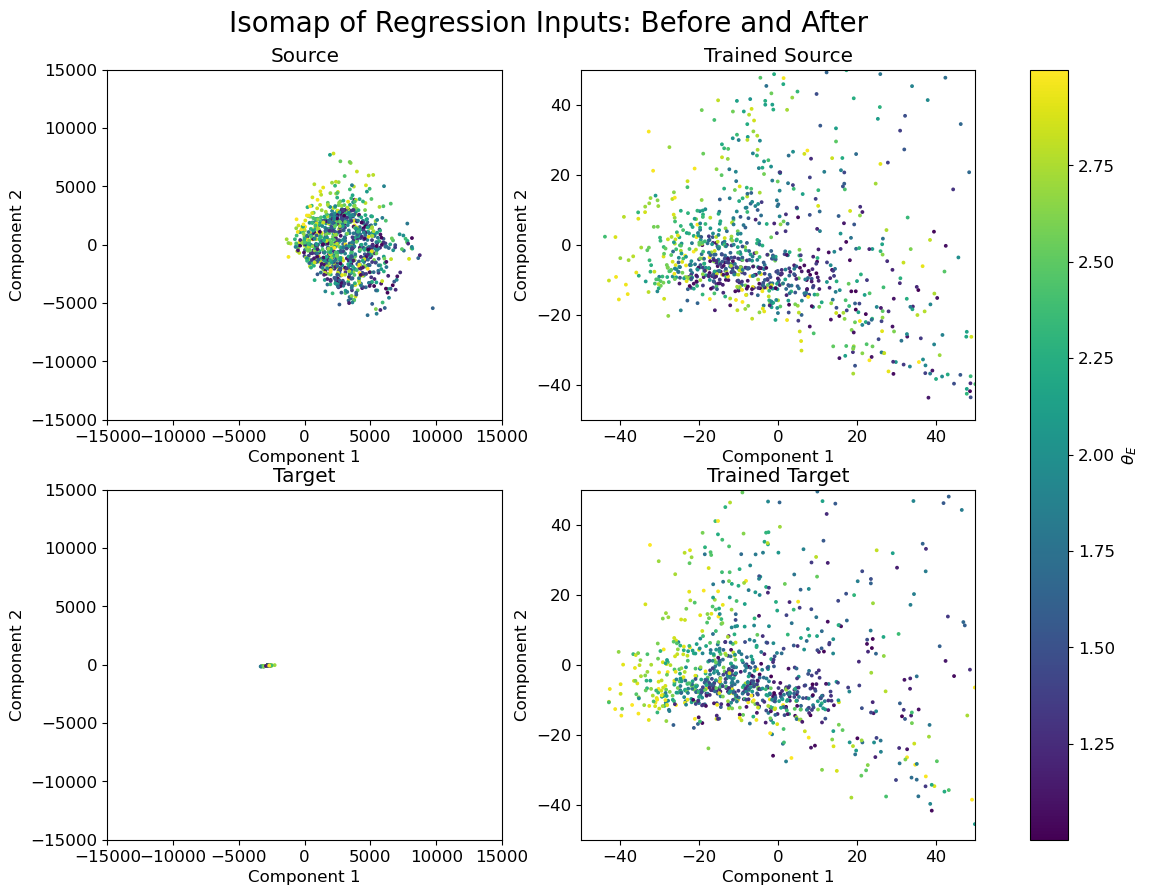


Epoch 60: 15.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1383
	Train Regression Loss: : 0.0269
	Train Mve Loss: : 3.1991
	Train R2 Score: : 0.9154
 Validation Statistics:
	Val Source Regression Loss: : 0.0249
	Val Target Regression Loss: : 0.0268
	Val Source R2 Score: : 0.9233
	Val Target R2 Score: : 0.9145
	Val Source Mve Loss: : 2.0840
	Val Target Mve Loss: : 1.8684

Epoch 61: 13.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1399
	Train Regression Loss: : 0.0372
	Train Mve Loss: : 1.2167
	Train R2 Score: : 0.8835
 Validation Statistics:
	Val Source Regression Loss: : 0.0245
	Val Target Regression Loss: : 0.0251
	Val Source R2 Score: : 0.9240
	Val Target R2 Score: : 0.9201
	Val Source Mve Loss: : 11.7256
	Val Target Mve Loss: : 9.1968

Epoch 62: 14.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1416
	Train Regression Loss: : 0.0285
	Train Mve Loss: : 1.3762
	Train R2 Score: : 0.9107
 Vali

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


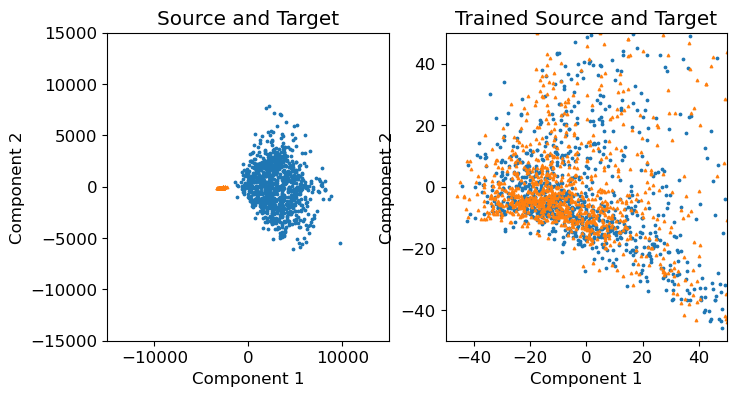

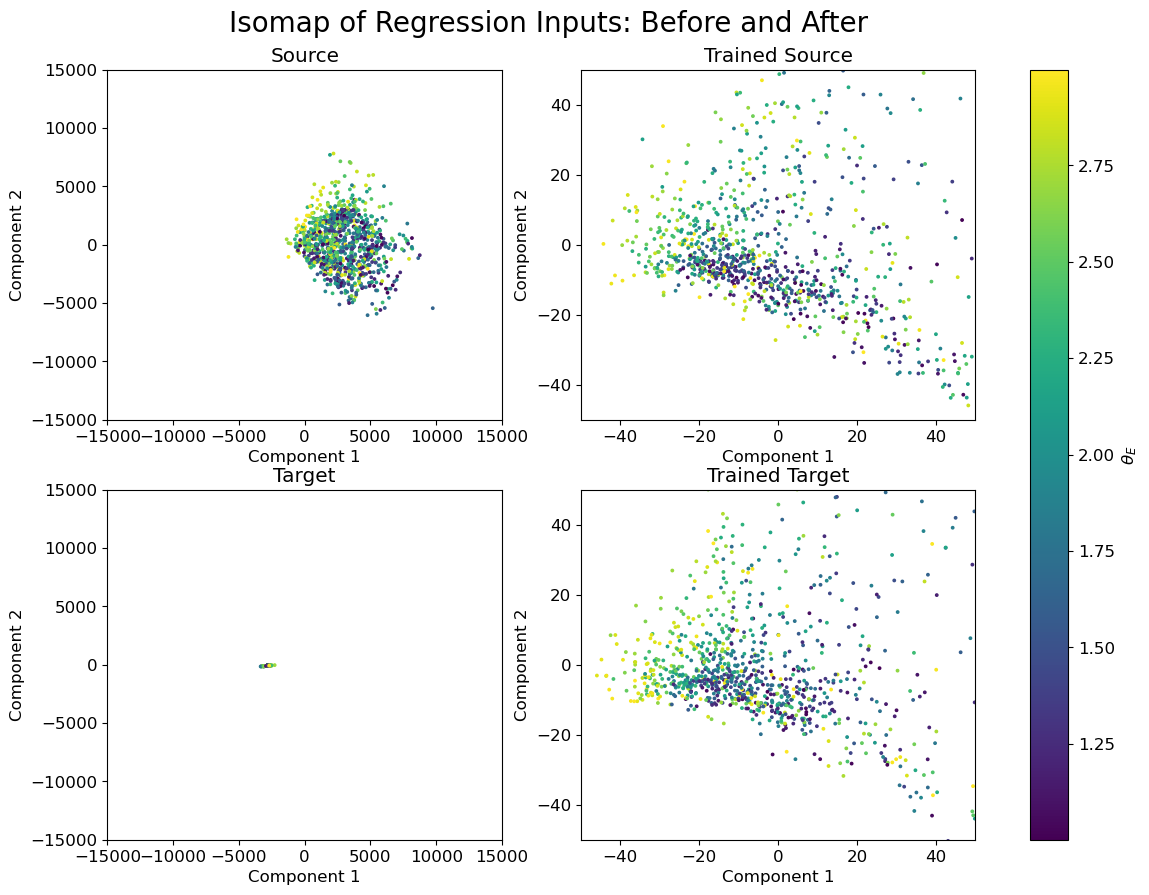


Epoch 65: 18.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1439
	Train Regression Loss: : 0.0512
	Train Mve Loss: : 1.4498
	Train R2 Score: : 0.8380
 Validation Statistics:
	Val Source Regression Loss: : 0.0430
	Val Target Regression Loss: : 0.0416
	Val Source R2 Score: : 0.8652
	Val Target R2 Score: : 0.8653
	Val Source Mve Loss: : 0.7563
	Val Target Mve Loss: : 0.7672
Saving Model MVE... Done.

Epoch 66: 18.71s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1445
	Train Regression Loss: : 0.0337
	Train Mve Loss: : 0.7836
	Train R2 Score: : 0.8936
 Validation Statistics:
	Val Source Regression Loss: : 0.0650
	Val Target Regression Loss: : 0.0665
	Val Source R2 Score: : 0.7943
	Val Target R2 Score: : 0.7850
	Val Source Mve Loss: : 1.4856
	Val Target Mve Loss: : 1.2271

Epoch 67: 14.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1446
	Train Regression Loss: : 0.0264
	Train Mve Loss: : 1.5645
	Train

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


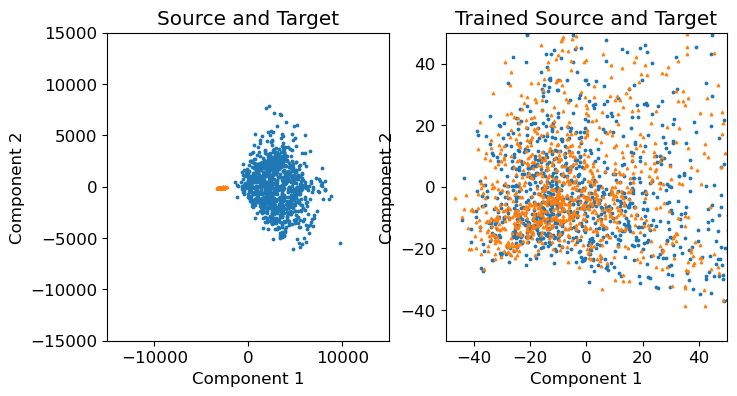

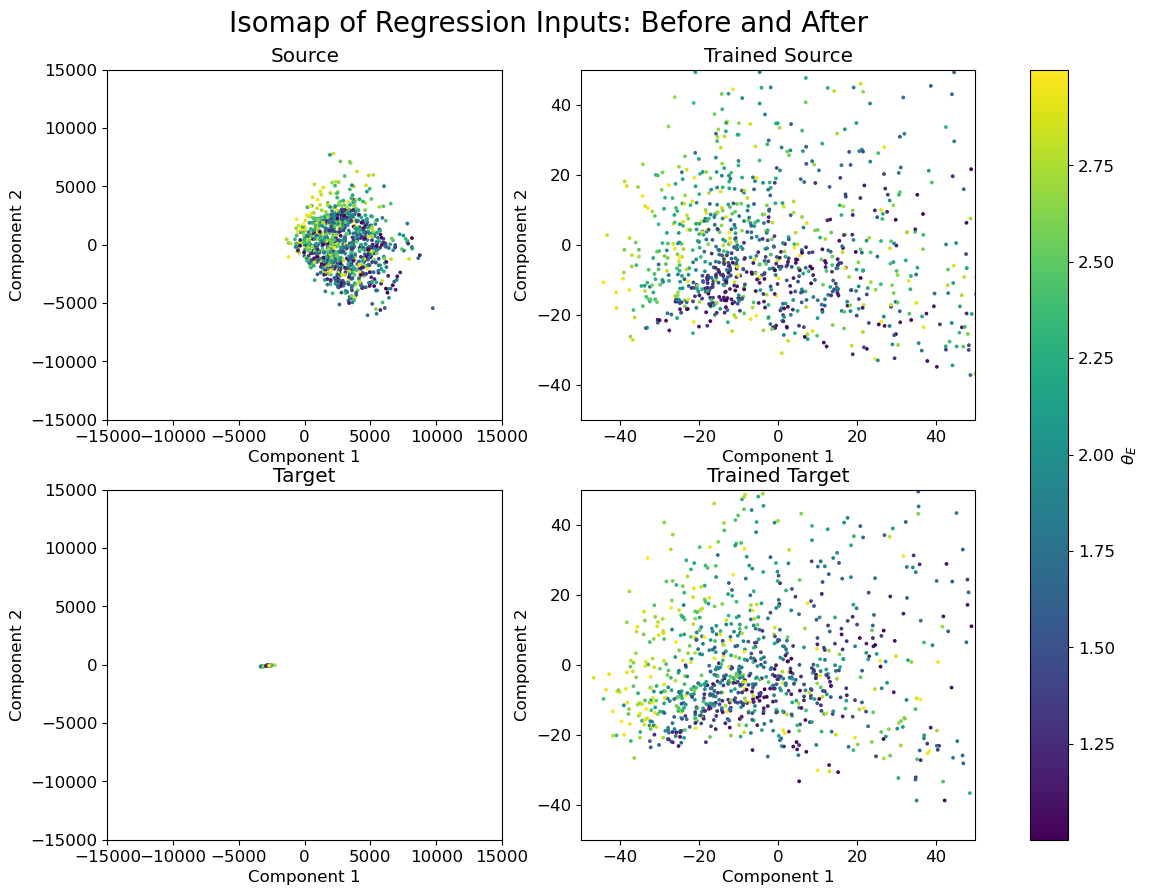

Saving Model MVE... Done.

Epoch 70: 15.91s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1447
	Train Regression Loss: : 0.0280
	Train Mve Loss: : 2.4420
	Train R2 Score: : 0.9119
 Validation Statistics:
	Val Source Regression Loss: : 0.0254
	Val Target Regression Loss: : 0.0298
	Val Source R2 Score: : 0.9212
	Val Target R2 Score: : 0.9048
	Val Source Mve Loss: : -0.1336
	Val Target Mve Loss: : -0.1395
Saving Model MVE... Done.

Epoch 71: 13.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1458
	Train Regression Loss: : 0.0267
	Train Mve Loss: : 0.2798
	Train R2 Score: : 0.9156
 Validation Statistics:
	Val Source Regression Loss: : 0.0261
	Val Target Regression Loss: : 0.0307
	Val Source R2 Score: : 0.9180
	Val Target R2 Score: : 0.9000
	Val Source Mve Loss: : 0.3639
	Val Target Mve Loss: : 1.3574

Epoch 72: 15.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1467
	Train Regression Loss: : 0.0309
	Tra

In [12]:
print("Beginning Training...")
mod_name = "models/mb_mvebeta_75epoch_aug2_2100"
# Train
best_target_R2 = -1.0
best_mve_loss = 1e6
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
        if (len(stats['val_target_r2_score']) > 0) and (stats['val_target_r2_score'][-1] > best_target_R2):
            print("Saving Model...", end = ' ')
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mod_name+'.json', 'w'))
            torch.save(state, mod_name)
            best_target_R2 = stats['val_target_r2_score'][-1]
            print("Done.")

        if (len(stats['val_target_mve_loss']) > 0) and (stats['val_target_mve_loss'][-1] < best_mve_loss):
            print("Saving Model MVE...", end = ' ')
            mve_name = mod_name + "_mve"
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mve_name+'.json', 'w'))
            torch.save(state, mve_name)
            best_mve_loss = stats['val_target_r2_score'][-1]
            print("Done.")
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, init_wt_da = 1.4, final_wt_da = 1.0, beta_init = 1.0, beta_final = 0.4)
#                         init_wt_mve = 6, final_wt_mve = 2)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i, beta_init = 1.0, beta_final = 0.4)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['val_source_mve_loss'].append(vals_validate[5])
        stats['val_target_mve_loss'].append(vals_validate[6])
        stats['epoch_no'] += 1

        
        print_epoch_scores(stats, i, time.time() - start_time)

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
mod_name = "models/mb_mvebetaFinal_75epoch_aug2_2100"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [33]:
mod_name = "models/mb_mvebeta_75epoch_aug2_2100_mve"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [34]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [109]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

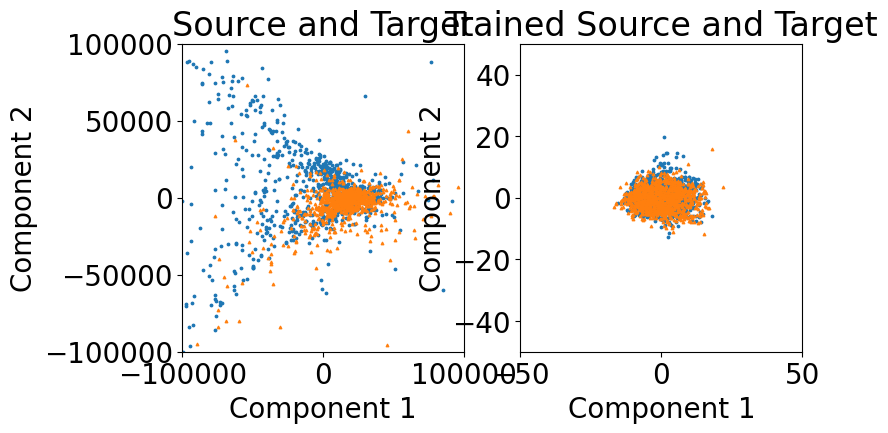

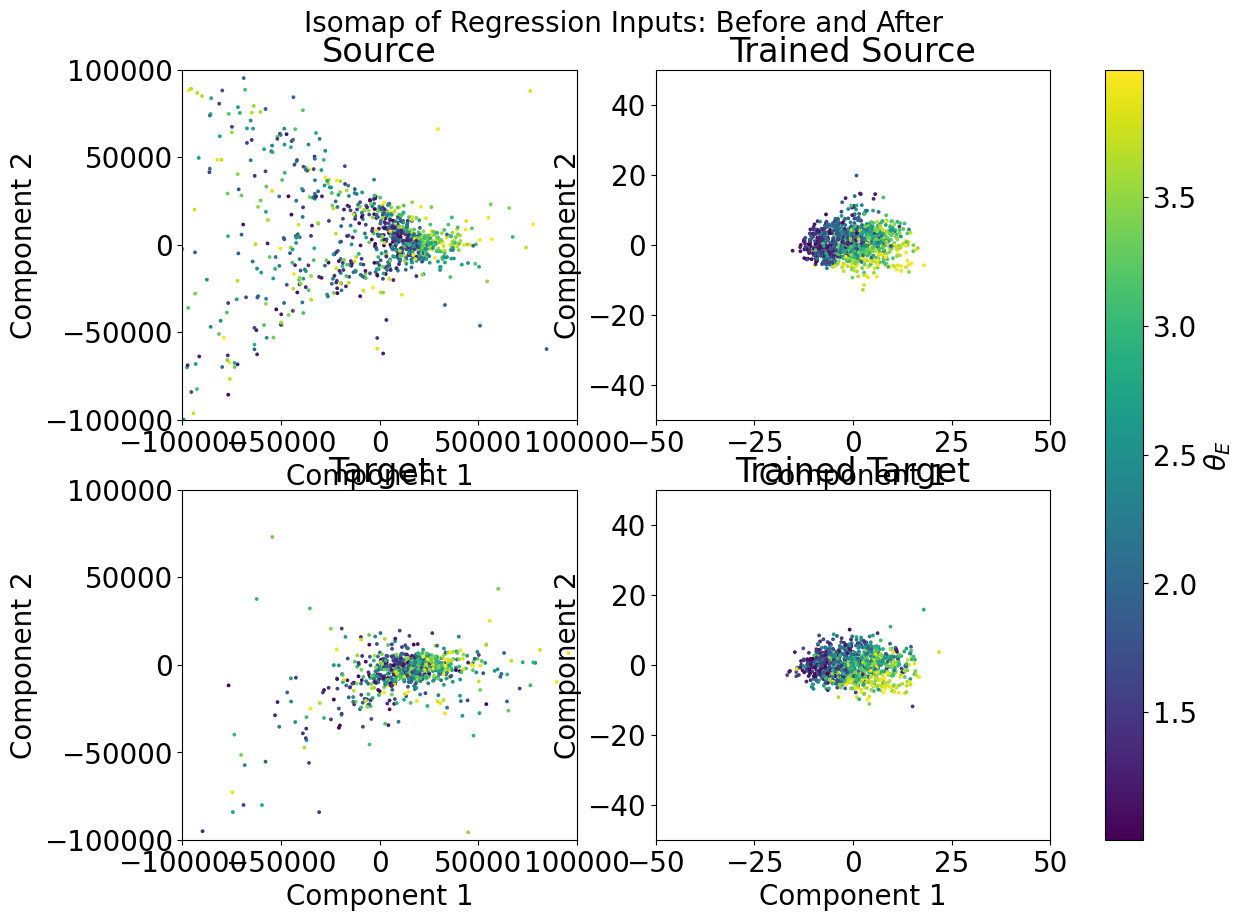

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [110]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 100000, 50)

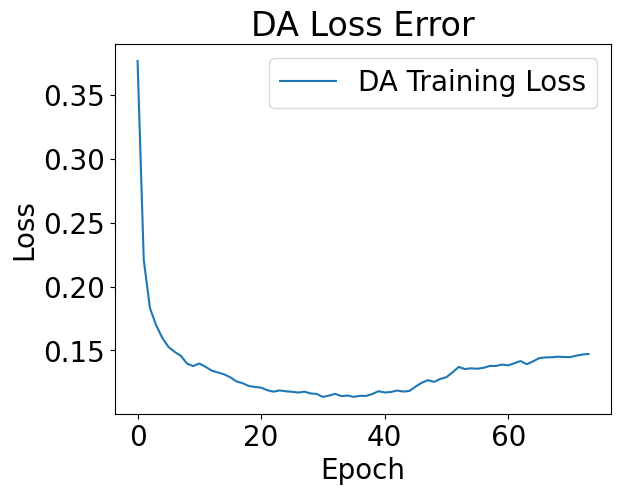

In [35]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

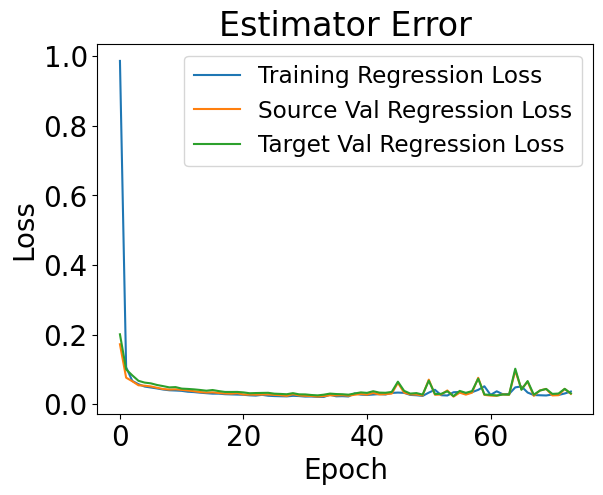

In [36]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 10.0)

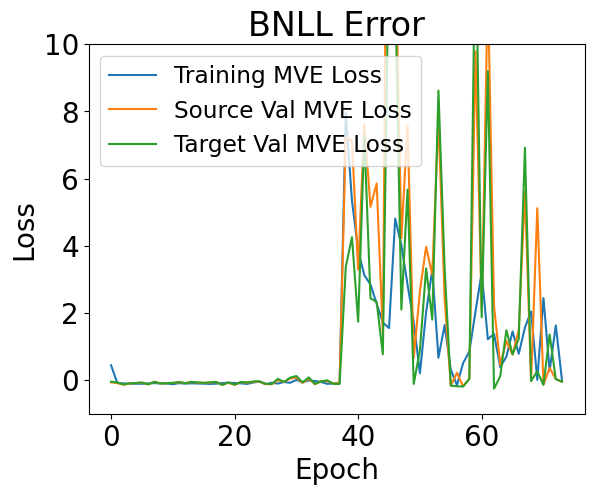

In [37]:
# Estimator
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 10)

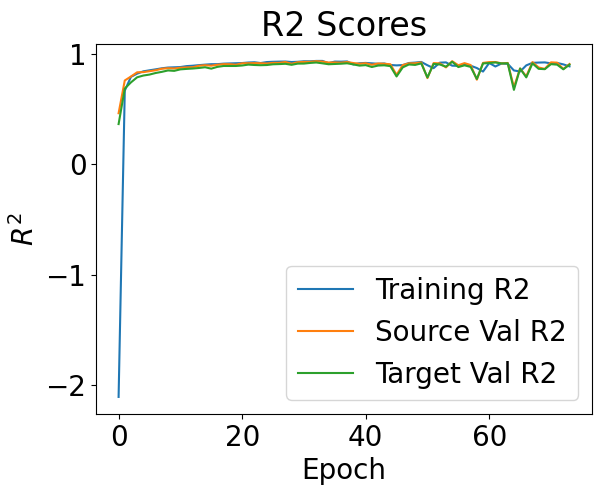

In [38]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.9039


Text(0.5, 1.0, 'MMD | Source | R2: 0.904')

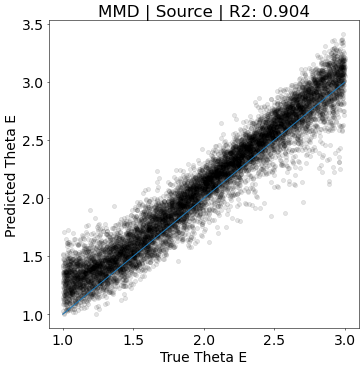

In [39]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.039')

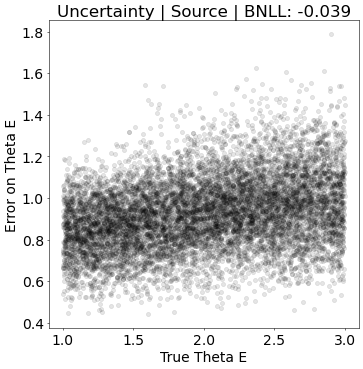

In [40]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

Target R2 Score is 0.9016


Text(0.5, 1.0, 'MMD | Target | R2: 0.902')

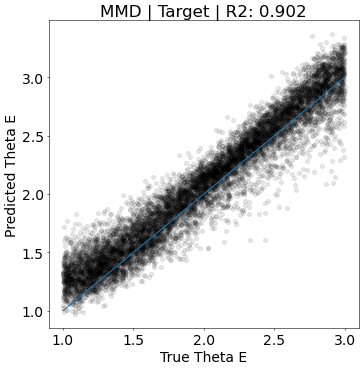

In [41]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.042')

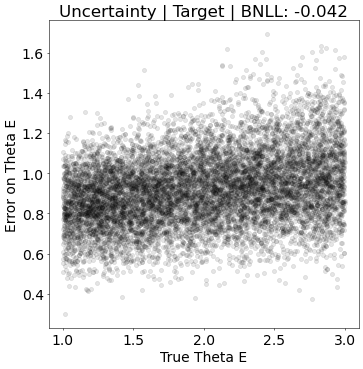

In [42]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [43]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

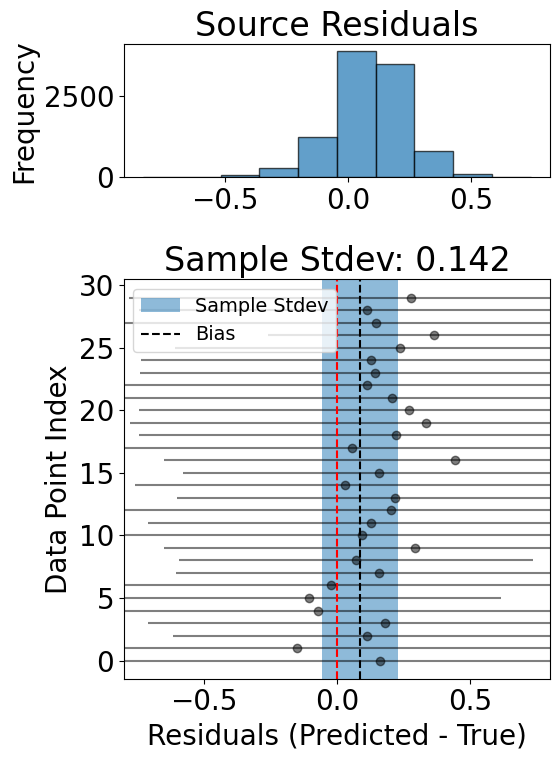

In [44]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

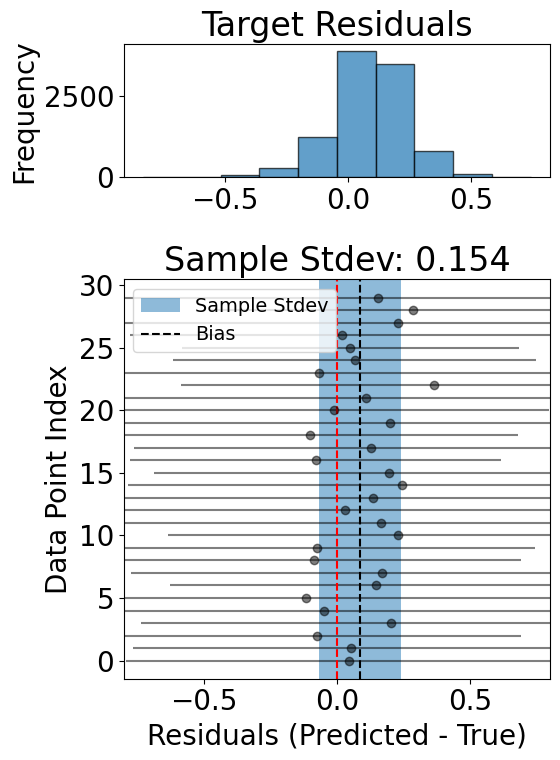

In [45]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [80]:
preds

array([1.30214167, 2.98077202, 2.00425458, ..., 0.95970899, 3.07219529,
       2.18891573])

In [81]:
true

array([1.69164467, 3.9343679 , 2.13911223, ..., 1.52133608, 2.09088802,
       2.36884522])

3.9343678951263428
2.980772018432617


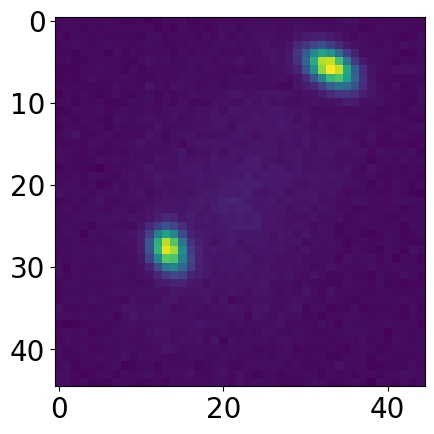

In [82]:
i = 0
b = 0
plt.imshow(imgs[idx][i, b, :, :])
print(true[idx][0])
print(preds[idx][0])

1.154159426689148
2.234156370162964


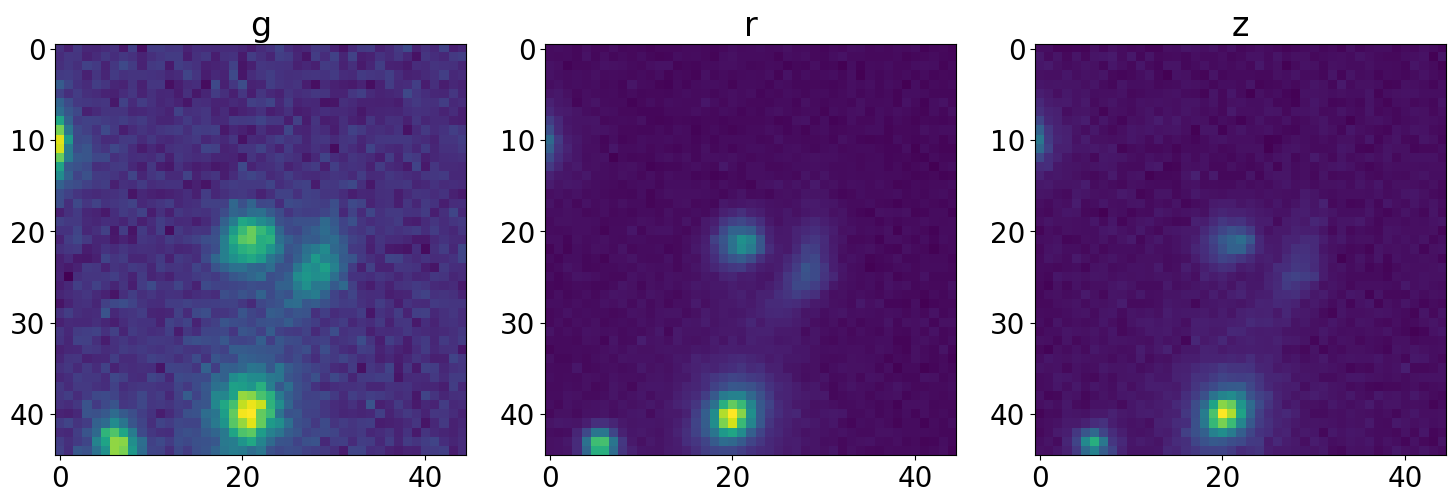

In [117]:
i = 134
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(imgs[idx][i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(imgs[idx][i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(imgs[idx][i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

print(true[idx][i])
print(preds[idx][i])
# Show the plot
plt.show()

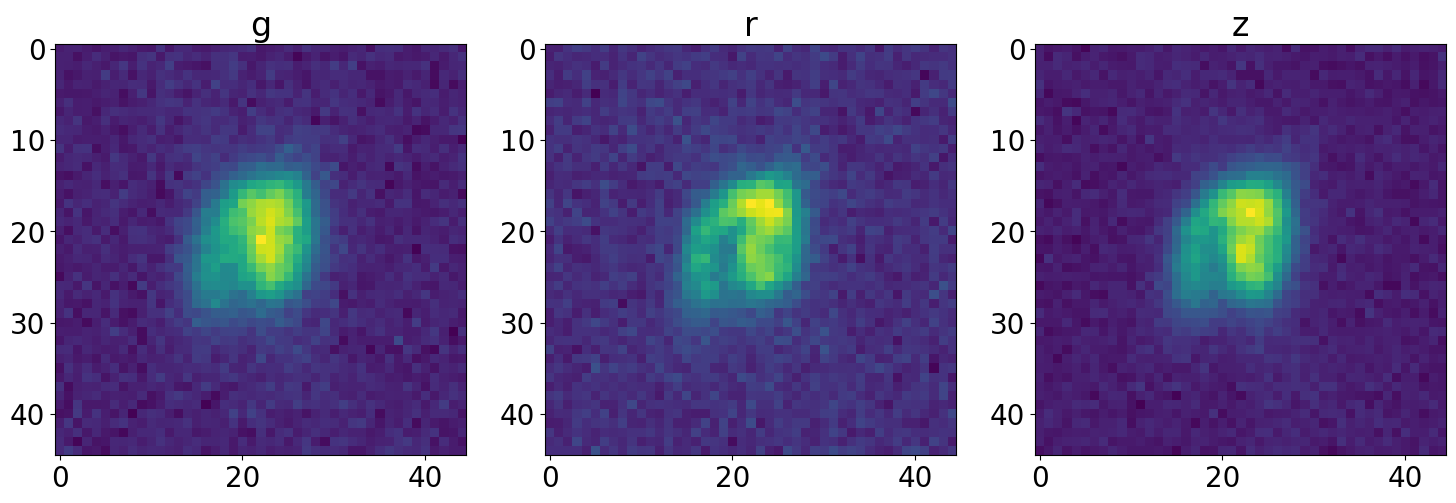

In [105]:
i = 16
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(source_data[i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(source_data[i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(source_data[i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()